## S-Mobile: Predicting Customer Churn
* Team-lead GitLab id: 243
* Group name: Korinna
* Team member names: Siqi Chen, Wen-Hsuan Hung, Xinyu Lou, Yuefeng Mao

## Setup

Please complete this Jupyter notebook by answering the questions in `s-mobile.pdf` on Canvas (week9/). Create a Notebook and HTML file with all your results and comments and push both the Notebook and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML from the Jupyter Notebook file without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the fourth group assignment for MGTA 455 and you will be using git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". git will not decide for you who's change to accept so the team-lead will have to determine which edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitLab. Make "pull first" a habit!

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import os
import urllib.request
import zipfile
from tempfile import NamedTemporaryFile as tmpfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import  OneHotEncoder

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc, make_scorer,mean_squared_error,r2_score
from sklearn.inspection import plot_partial_dependence 

import statsmodels.formula.api as smf 
from statsmodels.genmod.families import Binomial 
from statsmodels.genmod.families.links import logit 

import seaborn as sns

# increase plot resolution
mpl.rcParams["figure.dpi"] = 100

In [2]:
## load the data - this dataset must NOT be changed
s_mobile = pd.read_pickle("data/s_mobile.pkl")
s_mobile["churn_yes"] = rsm.ifelse(s_mobile["churn"] == "yes", 1, 0)

If you want access to the full 1M row dataset, use the code below to download and use the data. Please do **not** include the 1M row dataset in your repo!

The downside to using the dataset with 1M rows is, of course, that estimation time will increase substantially. I do NOT recommend you use this dataset to select your final model or for tuning hyper parameters. You can, however, use this larger dataset to re-estimate your chosen model and generate profit estimates for the representative sample.

In [3]:
## uncomment to run
# url = "https://www.dropbox.com/s/xhiexneeok9gyhs/s_mobile_1M.pkl.zip?dl=1"
# file_path, _ = urllib.request.urlretrieve(url)
# zip_file = zipfile.ZipFile(file_path, "r")
# s_mobile_tmp = zip_file.open(zip_file.namelist()[0])
# os.remove(file_path)
# s_mobile = pd.read_pickle(s_mobile_tmp)

In [4]:
# show dataset description
rsm.describe(s_mobile)

## S-mobile

Dataset used to investigate opportunities to decrease customer churn at S-mobile. The sample consists of three parts:

1. A training sample with 27,300 observations and a 50% churn rate ("training == 1")
2. A test sample with 11,700 observations and a 50% churn rate ("training == 0")
3. A representative sample with 30,000 observations and a churn rate of 2%, i.e., the actual monthly churn rate for S-mobile ("is.na(training)" or "representative == 1")

## Variables

* customer: Customer ID
* churn: Did consumer churn in the last 30 days? (yes or no)
* changer: % change in revenue over the most recent 4 month period
* changem: % change in minutes of use over the most recent 4 month period
* revenue: Mean monthly revenue in SGD
* mou: Mean monthly minutes of use
* overage: Mean monthly overage minutes
* roam: Mean number of roaming calls
* conference: Mean number of conference calls
* months: # of months the customer has had service with S-Mobile
* uniqsubs: Number of individuals listed on the customer account
* custcare: Mean number of calls to customer care 
* retcalls: Number of calls by the customer to the retention team
* dropvce: Mean number of dropped voice calls 
* eqpdays: Number of days customer has owned current handset
* refurb: Handset is refurbished (no or yes)
* smartphone: Handset is a smartphone (no or yes)
* creditr: High credit rating as opposed to medium or low (no or yes)
* mcycle: Subscriber owns a motorcycle (no or yes)
* car: Subscriber owns a car (no or yes)
* travel: Subscriber has traveled internationally (no or yes)
* region: Regions delineated by the 5 Community Development Council Districts (e.g., CS is Central Singapore)
* occupation: Categorical variable with 4 occupation levels (professional, student, retired, or other)
* training: 1 for training sample, 0 for test sample, NA for representative sample
* representative: 1 for representative sample, 0 for training and test sample


Use `smf.glm` with `freq_weights` and `cov_type` like in the below example
    
```python
lr = smf.glm(
    formula="churn_yes ~ changer + changem + ...",
    family=Binomial(link=logit()),
    data=pentathlon_nptb.query("training == 1"),
    freq_weights=s_mobile.loc[mobile.training == 1, "cweight"],
).fit(cov_type="HC1")
```

In [5]:
# run python code from another notebook
%run ./sub-notebooks/model1.ipynb

     index     OR   OR%  2.5%  97.5% p.values    
1  changer  1.001  0.1%   1.0  1.002    0.006  **


In [6]:
# importing functions from a module/package
from utils import functions

functions.example()


You just accessed a function from your first python packages!
Change the code in utils/function.py to whatever you need for this assignment
Use 'from utils import functions' to get access to your code
You can add modules to import from by adding additional .py files to the 'utils' directory
Note: If you make changes to the content of this file you will have to restart the notebook kernel to get the updates



In [3]:
pd.options.mode.chained_assignment = None

# Question answers

## Data Pre-processing

In [4]:
s_mobile["cweight"] = rsm.ifelse(s_mobile.churn == "yes", 2, 98)

In [5]:
to_std = s_mobile.loc[:, "changer":"eqpdays"].columns

# scale numeric variables by (x - mean(x)) / sd(x)
s_mobile_std = s_mobile.copy()
s_mobile_std[to_std] = rsm.scale_df(
   s_mobile[to_std], sf=1
)

In [6]:
s_mobile_train = s_mobile[s_mobile['training'] == 1]
s_mobile_test = s_mobile[s_mobile['training'] == 0]

## Question 1: Develop a model to predict customer churn  

### 1) Model comparison

#### A) Logistic Regression

In [11]:
lr = smf.glm(
        formula="churn_yes ~ changer + changem + revenue + mou + overage + roam + \
                 conference + months + uniqsubs + custcare + \
                 retcalls + dropvce + eqpdays + refurb + smartphone + highcreditr + mcycle + car + \
                 travel + region + occupation",
        family=Binomial(link=logit()), 
         data=s_mobile_train 
    ).fit(cov_type="HC1")

In [12]:
rsm.or_ci(lr,importance=True).sort_values('importance',ascending = False)

,index,OR,OR%,2.5%,97.5%,p.values,,dummy,importance
13,occupation[T.retired],0.187,-81.3%,0.166,0.211,< .001,***,True,5.353
3,highcreditr[T.yes],0.492,-50.8%,0.455,0.533,< .001,***,True,2.031
24,retcalls,2.023,102.3%,1.775,2.306,< .001,***,False,2.023
12,occupation[T.student],1.846,84.6%,1.675,2.035,< .001,***,True,1.846
10,region[T.SW],0.634,-36.6%,0.587,0.686,< .001,***,True,1.576
7,region[T.NE],0.643,-35.7%,0.595,0.694,< .001,***,True,1.556
9,region[T.SE],0.655,-34.5%,0.607,0.708,< .001,***,True,1.526
8,region[T.NW],0.665,-33.5%,0.615,0.718,< .001,***,True,1.504
11,occupation[T.professional],1.437,43.7%,1.346,1.535,< .001,***,True,1.437
1,refurb[T.yes],1.351,35.1%,1.254,1.456,< .001,***,True,1.351


In [13]:
s_mobile_test["pred_logit"] = lr.predict(s_mobile_test)

In [14]:
def score_fun(y_pred,y_true):
    AUC = roc_auc_score(y_true,y_pred)
    R2 =r2_score(y_true, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print('AUC ' + str(AUC))
    print('R2 ' + str(R2))
    print('RMSE ' + str(RMSE))
    
    return AUC,R2,RMSE

In [15]:
AUC_Logist, R2_Logist, RMSE_Logist = score_fun(s_mobile_test["pred_logit"],s_mobile_test["churn_yes"])

AUC 0.6950007451238222
R2 0.11875195823387075
RMSE 0.4693740623868476


In [7]:
columns = ['refurb' , 'smartphone' , 'highcreditr' , 'mcycle' , 'car' ,'travel' , 'region' , 'occupation']

X_train_catagroy= pd.get_dummies(s_mobile_std[columns])
X_num = s_mobile_std.loc[:,"changer":"eqpdays"]
X_index = s_mobile_std.loc[:,"training":"representative"]

X = pd.concat([X_train_catagroy,X_num,X_index],axis=1)

X_train = X[X['training']==1]
X_test = X[X['training']==0]
X_repre = X[X['representative']==1]

X_train = X_train.drop(['training','representative'],axis=1)
X_test =  X_test.drop(['training','representative'],axis=1)
X_repre = X_repre.drop(['training','representative'],axis=1)

Y_train = s_mobile_std[s_mobile_std['training']==1]["churn_yes"]
Y_test = s_mobile_std[s_mobile_std['training']==0]["churn_yes"]
Y_repre = s_mobile_std[s_mobile_std['representative']==1]["churn_yes"]

#### B) GradientBoosting

In [17]:
gb = GradientBoostingClassifier(learning_rate=0.55, max_depth=2, n_estimators=90).fit(X_train,Y_train)
# Evaluate test set 
s_mobile_test["pred_Boosting"] = gb.predict_proba(X_test)[:,1]

AUC_Boosting, R2_Boosting, RMSE_Boosting = score_fun(s_mobile_test["pred_Boosting"],s_mobile_test["churn_yes"])

AUC 0.7584466944261816
R2 0.20335098397239781
RMSE 0.44627598412518293


#### C) Random Forest

In [18]:
best_model_RF = RandomForestClassifier(n_estimators = 100, max_depth = 14).fit(X_train, Y_train)
s_mobile_test["pred_RF"] = best_model_RF.predict_proba(X_test)[:,1]

AUC_RF, R2_RF, RMSE_RF = score_fun(s_mobile_test["pred_RF"],s_mobile_test["churn_yes"])

AUC 0.7367186500109577
R2 0.16660726570496132
RMSE 0.4564517319210868


After grid search, regarding the AUC scores, we find Gradient Boosting model has the best performance on testing set, so we choose it for following calculation.

### 2) Re-estimation on 1M dataset

In [7]:
# uncomment to run
url = "https://www.dropbox.com/s/xhiexneeok9gyhs/s_mobile_1M.pkl.zip?dl=1"
file_path, _ = urllib.request.urlretrieve(url)
zip_file = zipfile.ZipFile(file_path, "r")
s_mobile_tmp = zip_file.open(zip_file.namelist()[0])
os.remove(file_path)
s_mobile_1M = pd.read_pickle(s_mobile_tmp)

In [8]:
to_std = s_mobile_1M.loc[:, "changer":"eqpdays"].columns

# scale numeric variables by (x - mean(x)) / sd(x)
s_mobile_1M_std = s_mobile_1M.copy()
s_mobile_1M_std[to_std] = rsm.scale_df(
   s_mobile_1M[to_std], sf=1
)

In [9]:
X = pd.get_dummies(s_mobile_1M_std.loc[:,"changer":"occupation"])

s_mobile_1M_std["churn_yes"] = rsm.ifelse(s_mobile_1M["churn"] == "yes", 1, 0)
Y = s_mobile_1M_std["churn_yes"]

In [10]:
gb = GradientBoostingClassifier(learning_rate=0.55, max_depth=2, n_estimators=90).fit(X,Y)

### 3) Calculate and check churn probabilities on representative set

In [11]:
s_mobile_repre = s_mobile_std[s_mobile_std['representative'] == 1]

In [12]:
X_repre = pd.get_dummies(s_mobile_std[s_mobile_std.representative==1].loc[:,"changer":"occupation"])
Y_repre = s_mobile_std[s_mobile_std.representative==1]["churn_yes"]

In [13]:
s_mobile_repre["pred_Boosting"] = gb.predict_proba(X_repre)[:,1]

In [14]:
np.mean(s_mobile_repre["pred_Boosting"])

0.025576560758160945

### 4) Calculate Variable importance and Partial dependence

In [22]:
def importance(clf, X, y, cn):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    data.columns = cn
    order = data.agg("mean").sort_values(ascending=False).index[:16]
    fig = sns.barplot(
        x="value", y="variable", color="slateblue", data=pd.melt(data[order])
    )
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)
    #fig.set_ylabel("Y Label",fontsize=20)
    #fig.tick_params(labelsize=5)
    return data[order],fig

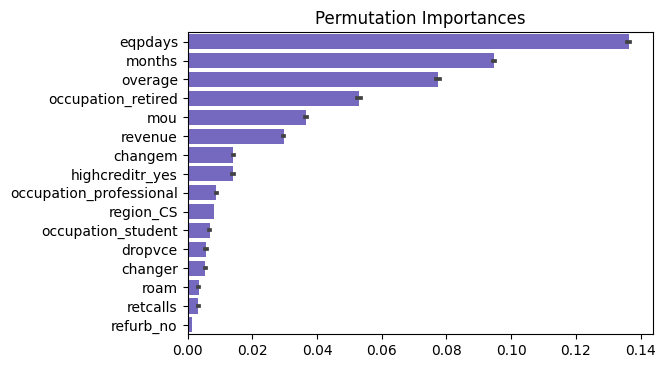

In [23]:
order, fig = importance(gb,X,Y,X.columns)

In [25]:
order.mean()

eqpdays                    0.136377
months                     0.094701
overage                    0.077417
occupation_retired         0.053108
mou                        0.036622
revenue                    0.029702
changem                    0.014139
highcreditr_yes            0.014024
occupation_professional    0.008795
region_CS                  0.008190
occupation_student         0.006810
dropvce                    0.005677
changer                    0.005481
roam                       0.003428
retcalls                   0.003362
refurb_no                  0.001272
dtype: float64

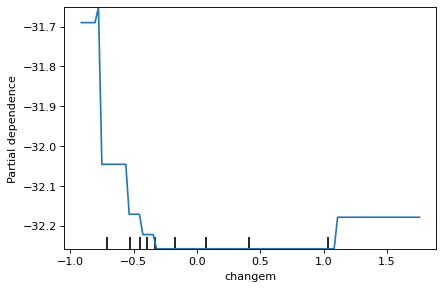

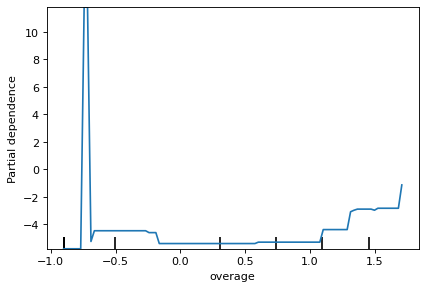

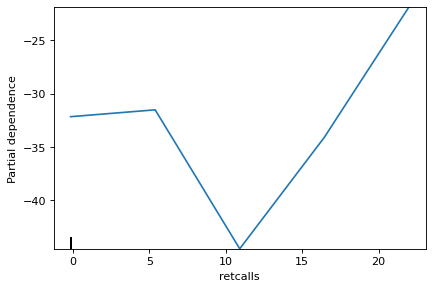

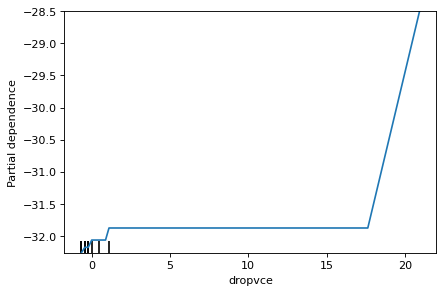

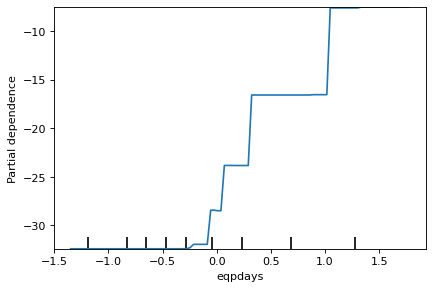

In [24]:
disp2 = plot_partial_dependence(gb, X, [1]) 
disp2 = plot_partial_dependence(gb,X, [4]) 
disp2 = plot_partial_dependence(gb, X, [10]) 
disp2 = plot_partial_dependence(gb, X_repre, [11]) 
disp2 = plot_partial_dependence(gb, X_repre, [12])

## Question 2: Analysis of model output from logistic regression 

In [23]:
lr = smf.glm(
        formula="churn_yes ~ changer + changem + revenue + mou + overage + roam + \
                 conference + months + uniqsubs + custcare + \
                 retcalls + dropvce + eqpdays + refurb + smartphone + highcreditr + mcycle + car + \
                 travel + region + occupation",
        family=Binomial(link=logit()), 
        data=s_mobile_std.query("training == 1"), 
        freq_weights=s_mobile_std.query("training == 1")["cweight"], 
    ).fit(cov_type="HC1")

In [24]:
rsm.or_ci(lr,importance=True).sort_values("importance",ascending=False).reset_index()

,level_0,index,OR,OR%,2.5%,97.5%,p.values,,dummy,importance
0,13,occupation[T.retired],0.184,-81.6%,0.171,0.199,< .001,***,True,5.422
1,3,highcreditr[T.yes],0.483,-51.7%,0.463,0.504,< .001,***,True,2.069
2,12,occupation[T.student],1.900,90.0%,1.820,1.983,< .001,***,True,1.900
3,10,region[T.SW],0.627,-37.3%,0.604,0.650,< .001,***,True,1.595
4,7,region[T.NE],0.644,-35.6%,0.621,0.668,< .001,***,True,1.553
5,9,region[T.SE],0.651,-34.9%,0.627,0.675,< .001,***,True,1.537
6,8,region[T.NW],0.660,-34.0%,0.636,0.684,< .001,***,True,1.516
7,11,occupation[T.professional],1.416,41.6%,1.372,1.460,< .001,***,True,1.416
8,26,eqpdays,1.366,36.6%,1.344,1.388,< .001,***,False,1.366
9,18,overage,1.341,34.1%,1.319,1.363,< .001,***,False,1.341


From the importance scores of logistic regression, we find the top 5 factors affecting customer churn rate are occupation, high credit rating, region, eqpdays, and overage.

` occupation[T.retired] `
The level "retired" in occupation is the variable with highest importance score of 5.422. Its OR is 0.184, which means compared to reference level ("other"), with other features remaining the same, a switch from "other" to "retired" in occupation will decrease the churn rate by 81.6%.

` highcreditr[T.yes] `
The level "yes" in highcreditr is the variable with 2nd highest importance score of 2.069. Its OR is 0.483, which means compared to reference level ("no"), with other features remaining the same, a switch from "no" to "yes" in highcreditr will decrease the churn rate by 51.7%.

` occupation[T.student] `
The level "student" in occupation is the variable with 3rd highest importance score of 1.900. Its OR is 1.900, which means compared to reference level ("other"), with other features remaining the same, a switch from "other" to "student" in occupation will increase the churn rate by 90.0%.

` region[T.SW] `
The level "SW" in region is the variable with 4th highest importance score of 1.595. Its OR is 0.627, which means compared to reference level ("CS"), with other features remaining the same, a switch from "CS" to "SW" in region will decrease the churn rate by 37.3%.

` region[T.NE] `
The level "NE" in region is the variable with 5th highest importance score of 1.553. Its OR is 0.644, which means compared to reference level ("CS"), with other features remaining the same, a switch from "CS" to "NE in region will decrease the churn rate by 35.6%.

` region[T.SE] `
The level "SE" in region is the variable with 6th highest importance score of 1.537. Its OR is 0.651, which means compared to reference level ("CS"), with other features remaining the same, a switch from "CS" to "SE" in region will decrease the churn rate by 34.9%.

` region[T.NW] `
The level "NW" in region is the variable with 7th highest importance score of 1.516. Its OR is 0.660, which means compared to reference level ("CS"), with other features remaining the same, a switch from "CS" to "NW" in region will decrease the churn rate by 34.0%.

` occupation[T.professional] `
The level "professional" in occupation is the variable with 8th highest importance score of 1.416. Its OR is 1.416, which means compared to reference level ("other"), with other features remaining the same, a switch from "other" to "professional" in occupation will increase the churn rate by 41.6%.

` eqpdays `
Eqpdays is the variable with 9th highest importance score of 1.366. Its OR is 1.366, which means with other features remaining the same, a one-unit increase in eqpdays will increase the churn rate by 36.6%.

` overage `
Overage is the variable with 10th highest importance score of 1.341. Its OR is 1.341, which means with other features remaining the same, a one-unit increase in overage will increase the churn rate by 34.1%.

## Question 3: Develop actions/offers/incentives 

`Below part is based on the result of the boosting model. `

` Usage Trend: changem `
Changem is the most significant variable in the Usage Trend variable type. Its permutation importance is 0.014, which is the 7th most important feature in the model. 

Policy: To cut down the number of people whose changem is low or negative, and reduce churn rate, we need to identify what cause people to call less in the current four months. Is it because the fee is high? Or is it because the call quality is low? After identifying the problem, we offer promotions to try to turn the negatives to close to 0.5 of the original value as possible. We assume that the action can increase the call time for those whose current percentage is negative to grow 50%.

`Customer Usage: Overage`
Overage is the most significant variable in the Customer Usage variable type. Its permutation importance is 0.077, which is the the 3rd  most important feature in the model. 

Policy: We offer promotions for bigger packages. Users do not need to pay extra for overage over 150. 

`Customer Action: Retcalls`
Retention calls is the most significant variable in the Customer Action variable type. Its permutation importance is 0.003, which is the 15th most important feature in the model. 

Policy: In order to reduce retention call amounts, we can first identify and summarize frequent issues callers complain about, work on solutions and try to minimize the chance these issues occur. Furthermore, we can also train the retention team to improve their performance so that customers can resolve their issues in as few phone calls as possible. We assume two actions combined can reduce the retention call amount by 50%. 

`Quality: Dropvce`
Dropvce (dropped voice calls) is the most significant variable in the Quality variable type. Its permutation importance is 0.006, which is the 12th most important feature in the model. 

Policy: In order to reduce dropped voice call amounts, we can first alert customers when the network is unstable and let them choose whether to still continue the call. We can also partner with an advanced network operations technology company to monitor hyper-network elements to help ensure continued uptime and minimize disruption. We assume two actions combined can reduce the dropped voice call amounts which are greater than 2 by 1. 

`Equipment characteristic: Eqpdays`
Eqpdays (days customer has owned current handset) is the most significant variable in the Equipment Characteristic variable type. Its permutation importance is 0.136, which is the most important feature in the model. 

Policy: In order to reduce Eqpdays amounts, we can send new handset promotion emails to customers after 250 days since the customer had the handset (from the plot below we can see that people start to churn after they has the handsets 250 days). We can also offer trade-in service for customers (eqpday>250) that they can replace their old handsets with some new contract device in lower prices. We assume two actions combined can reduce the Eqpdays amount by 30%. 

`Customer characteristic: Occupation`
Occupation is the most significant variable in the Customer Characteristic variable type. Occupation_retired have the highest permutation importance among all the occupation category, which is 0.053. It is ranked top 4 among all the features in the model. 

Policy: Since retired users are most likely to churn, and students are less likely to churn. We would target more student users in the future. For students, we would offer them discounts in August, September when the new semester starts.


## Question 4: Quantify the impact of these actions/offers/incentives 

In [15]:
def prediction(s_mobile,model):

    to_std = s_mobile.loc[:, "changer":"eqpdays"].columns

    s_mobile_std = s_mobile.copy()
    s_mobile_std[to_std] = rsm.scale_df(
           s_mobile[to_std], sf=1
    )

    #s_mobile_train = s_mobile_std[s_mobile_std['training'] == 1]
    #s_mobile_test = s_mobile_std[s_mobile_std['training'] == 0]
    #s_mobile_repre = s_mobile_std[s_mobile_std['representative'] == 1]

    s_mobile_repre = s_mobile_std[s_mobile_std['representative'] == 1]
    
    X_repre = pd.get_dummies(s_mobile_repre.loc[:,"changer":"occupation"])

    Y_repre = s_mobile_std[s_mobile_std['representative']==1]["churn_yes"]
    
    s_mobile_repre[model] = gb.predict_proba(X_repre)[:,1]
    
    mean_churn_rate = np.mean(s_mobile_repre[model])
    
    print(f"Avg churn rate of representative customers: {mean_churn_rate:,.8f}")
    
    return s_mobile_repre,mean_churn_rate

In [16]:
s_mobile_repre,mean_churn_rate_base = prediction(s_mobile,model="pred_Boosting")

Avg churn rate of representative customers: 0.02557656


In [17]:
s_mobile_changem = s_mobile.copy()
s_mobile_changem['changem'] = rsm.ifelse(s_mobile_changem['changem'] < 0 , s_mobile_changem['changem']*0.5, s_mobile_changem['changem'])

s_mobile_overage = s_mobile.copy()
s_mobile_overage['overage'] = rsm.ifelse(s_mobile['overage'] > 150 , 150, s_mobile['overage'])

s_mobile_retcalls = s_mobile.copy()
for i in range(len(s_mobile_retcalls)):
    if s_mobile_retcalls['retcalls'].iloc[i] == 1:
        s_mobile_retcalls['retcalls'].iloc[i]  = 0
    elif s_mobile_retcalls['retcalls'].iloc[i]  >= 2:
        s_mobile_retcalls['retcalls'].iloc[i] = 1
        
s_mobile_dropvce = s_mobile.copy()
s_mobile_dropvce['dropvce'] = rsm.ifelse(s_mobile['dropvce'] > 2 , s_mobile['dropvce'] -1, s_mobile['dropvce'])

s_mobile_eqpdays = s_mobile.copy()
s_mobile_eqpdays['eqpdays'] = rsm.ifelse(s_mobile['eqpdays'] > 250 , s_mobile['eqpdays']*0.7, s_mobile['eqpdays'])

In [18]:

s_mobile_overage_repre,mean_churn_rate_overage = prediction(s_mobile_overage,model="pred_Boosting")
s_mobile_eqpdays_repre,mean_churn_rate_eqpdays = prediction(s_mobile_eqpdays,model="pred_Boosting")
s_mobile_dropvce_repre,mean_churn_rate_dropvce = prediction(s_mobile_dropvce,model="pred_Boosting")
s_mobile_changem_repre,mean_churn_rate_changem = prediction(s_mobile_changem,model="pred_Boosting")
s_mobile_retcalls_repre,mean_churn_rate_retcalls = prediction(s_mobile_retcalls,model="pred_Boosting")

action_compare=pd.DataFrame({
    'name' : ['baseline','changem','overage' ,'dropvce','eqpdays','retcalls'],
    'churn_rate':[mean_churn_rate_base,mean_churn_rate_changem,mean_churn_rate_overage,mean_churn_rate_dropvce,mean_churn_rate_eqpdays,mean_churn_rate_retcalls],
})
action_compare['diff'] = action_compare['churn_rate'] - action_compare['churn_rate'].iloc[0]
action_compare

Avg churn rate of representative customers: 0.02561847
Avg churn rate of representative customers: 0.02524625
Avg churn rate of representative customers: 0.02545603
Avg churn rate of representative customers: 0.02492484
Avg churn rate of representative customers: 0.02707618


,name,churn_rate,diff
0,baseline,0.025577,0.000000
1,changem,0.024925,-0.000652
2,overage,0.025618,0.000042
3,dropvce,0.025456,-0.000121
4,eqpdays,0.025246,-0.000330
5,retcalls,0.027076,0.001500


After applying the action we mentioned previously, we calculated the churn rate for each selected variable. The result shows that `overage`, `dropvce` have the same churn rate as baseline model, `changem` has a higher churn than baseline, and `eqpdays`, `retcalls` have lower churn rate than baseline, Most importantly, `eqpdays` has the lowest churn rate.


To make sure that students are less likely to churn, and retired users , and that our strategy to target more students is correct, we will conduct another analysis in the following four months, and make sure that the the same pattern that  still exist

## Question 5: Decide target customers

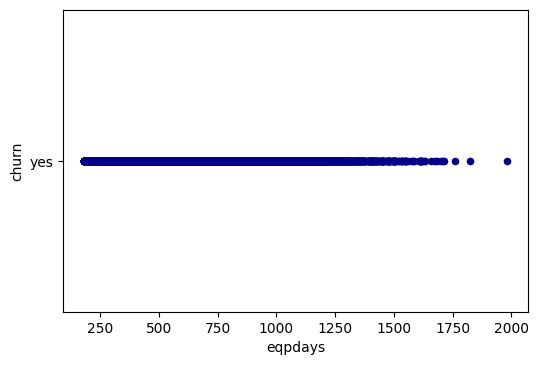

In [23]:
ax1 = s_mobile[s_mobile['churn_yes']==1].plot.scatter(x='eqpdays', y='churn', c='DarkBlue')

`Usage Trend: changem`
Policy mainly focuses on encouraging people whose changem is lower to call more. For customers with negative changem (meaning these users have lower minutes of use in the current four months compared with previous four months, we offer promotions (cheaper fee of calls) to increase their willingness to call. \
`Customer Usage: Overage`
Policy mainly focuses on customers with a rather high amount of overage (over 150). Users don’t have to pay extra if the the overage minutes is more than 150 minutes. The goal for this policy is to eventually reduce the amount customers have to pay when they generate a big overage. Therefore, by offering special discounts for bigger packages, we can provide incentive for customers to switch to a bigger package, thus lowering overage amount. \
`Customer Action: Retcalls`
Policy mainly focuses on reducing retention calls by improving our performance and efficiency. By improving the retention team’s efficiency, we target customers with multiple retention calls and try to solve all their issues within one phone call. By identifying and fixing potential problems, we target the entire customer group and try to offer them a smoother user experience. \
`Quality: Dropvce`
Policy mainly focuses on customers experiencing dropped voice calls. By alerting customers and minimizing disruptions, we can reduce the amount of dropped voice calls and eventually reduce the churn rates.  \
`Equipment characteristic: Eqpdays`
Policy mainly focuses on customers who have had their current handset for over 250 days, since that is when customers start to churn. The special trade-in offers will provide incentives for customers to renew their device, thus resetting the Eqpdays to 0. \
`Customer characteristic: Occupation`
Policy mainly focuses on student users, who have a lower churn rate than other groups. We would target more students, and offer them discounts in August and September when the new semester begins. 


## Question 6: Using a 5-year (60 month) time window to evaluate CLV

### 1) Define the assumptions and calculation method of CLV
Assumptions: \
`Monthly discount rate: `\
We assume that the annual discount rate is 10%, and calculate the monthly discount accordingly.
Monthly Discount Rate = ( 1 + 10% ) ^ ( 1/12 ) - 1	
`Cost: `\
Since we are trying to reduce the customer’s churn rate, we assume everyone is an existing customer, and disregard all the fixed costs like cell tower construction costs. We only consider the human resources here when calculating costs. 
In the given dataset, calls to the retention center and to customer care will make up most part of the customer service needs. Therefore we add these two columns together to calculate the total number of service phone calls (166493). 


In [19]:
service_call = np.sum(s_mobile['custcare'] + s_mobile['retcalls']) 
service_call

166493.0

Then we assume each phone call lasts around 10 mins, and according to Google, the average customer service staff’s salary is around 15 dollars/hr. We can then calculate the total amount of monthly cost for the entire customer group, and dividing the result by the number of customers gives us the average cost for a single customer (6 dollars)

In [20]:
cost = round((service_call * 10/ 60 * 15) / len(s_mobile), 0)
cost

6.0

In [21]:
s_mobile_repre,mean_churn_rate_base = prediction(s_mobile,model="pred_Boosting")

Avg churn rate of representative customers: 0.02557656


In [22]:
annual_discount_rate = 0.1
monthly_discount_rate = (1+annual_discount_rate)**(1/12)-1
cost = 6

def clv_calc(df_whole,df,model):
    DF_clv = pd.DataFrame( {'customer':df['customer'],'revenue':df_whole[df_whole['representative']==1]['revenue'],'cost':cost,'churn':df[model] })
    DF_clv['profit']=DF_clv['revenue']-DF_clv['cost']
    profit_pv=[]
    for i in range(0,60):
        active_rate = (1-DF_clv['churn'])**(i)
        p = np.sum(active_rate*DF_clv['profit'])
        p_pv = p/((1+monthly_discount_rate)**(i))
        profit_pv.append(p_pv)
    total_profit_pv = np.sum(profit_pv)
    print(f"Expected total CLV of representative customer: S${total_profit_pv:,.2f}")
    
    return(round(total_profit_pv,2))
    

### 2) Calculate the CLVs of baseline and different actions

In [23]:
baseline = clv_calc(s_mobile, s_mobile_repre, model="pred_Boosting")

Expected total CLV of representative customer: S$50,308,664.04


In [24]:
s_mobile_changem = s_mobile.copy()
s_mobile_changem['changem'] = rsm.ifelse(s_mobile_changem['changem'] < 0 , s_mobile_changem['changem']*0.5, s_mobile_changem['changem'])
s_mobile_changem_repre,mean_churn_rate_changem = prediction(s_mobile_changem,model="pred_Boosting")
changem = clv_calc(s_mobile_changem,s_mobile_changem_repre,model="pred_Boosting")

Avg churn rate of representative customers: 0.02492484
Expected total CLV of representative customer: S$50,574,451.82


In [25]:
s_mobile_overage = s_mobile.copy()
s_mobile_overage['overage'] = rsm.ifelse(s_mobile['overage'] > 150 , 150, s_mobile['overage'])
s_mobile_overage_repre,mean_churn_rate_overage = prediction(s_mobile_overage,model="pred_Boosting")
overage = clv_calc(s_mobile_overage,s_mobile_overage_repre,model="pred_Boosting")

Avg churn rate of representative customers: 0.02561847
Expected total CLV of representative customer: S$51,052,248.96


In [26]:
s_mobile_retcalls = s_mobile.copy()

for i in range(len(s_mobile_retcalls)):
    if s_mobile_retcalls['retcalls'].iloc[i] == 1:
        s_mobile_retcalls['retcalls'].iloc[i]  = 0
    elif s_mobile_retcalls['retcalls'].iloc[i]  >= 2:
        s_mobile_retcalls['retcalls'].iloc[i] = 1

# s_mobile_retcalls['retcalls'] = rsm.ifelse(s_mobile['retcalls'] < 2 , 0, s_mobile['retcalls'])
        
s_mobile_retcalls_repre,mean_churn_rate_retcalls = prediction(s_mobile_retcalls,model="pred_Boosting")
retcalls = clv_calc(s_mobile_retcalls,s_mobile_retcalls_repre,model="pred_Boosting")

Avg churn rate of representative customers: 0.02707618
Expected total CLV of representative customer: S$50,462,112.52


In [27]:
s_mobile_dropvce = s_mobile.copy()
s_mobile_dropvce['dropvce'] = rsm.ifelse(s_mobile['dropvce'] > 2 , s_mobile['dropvce'] -1, s_mobile['dropvce'])
s_mobile_dropvce_repre,mean_churn_rate_dropvce = prediction(s_mobile_dropvce,model="pred_Boosting")
dropvce = clv_calc(s_mobile_dropvce,s_mobile_dropvce_repre,model="pred_Boosting")

Avg churn rate of representative customers: 0.02545603
Expected total CLV of representative customer: S$50,386,157.54


In [28]:
s_mobile_eqpdays = s_mobile.copy()
s_mobile_eqpdays['eqpdays'] = rsm.ifelse(s_mobile['eqpdays'] > 250 , s_mobile['eqpdays']*0.7, s_mobile['eqpdays'])
s_mobile_eqpdays_repre,mean_churn_rate_eqpdays = prediction(s_mobile_eqpdays,model="pred_Boosting")
eqpdays = clv_calc(s_mobile_eqpdays,s_mobile_eqpdays_repre,model="pred_Boosting")

Avg churn rate of representative customers: 0.02524625
Expected total CLV of representative customer: S$50,347,400.79


### 3) Comparison of different actions

In [29]:
action_compare=pd.DataFrame({
    'name' : ['baseline','changem','overage' ,'dropvce','eqpdays','retcalls'],
    'churn_rate':[mean_churn_rate_base,mean_churn_rate_changem,mean_churn_rate_overage,mean_churn_rate_dropvce,mean_churn_rate_eqpdays,mean_churn_rate_retcalls],
    'CLV' : [baseline, changem, overage,dropvce,eqpdays,retcalls ]
})
action_compare['diff'] = action_compare['CLV'] - action_compare['CLV'].iloc[0]
action_compare

,name,churn_rate,CLV,diff
0,baseline,0.025577,50308664.04,0.00
1,changem,0.024925,50574451.82,265787.78
2,overage,0.025618,51052248.96,743584.92
3,dropvce,0.025456,50386157.54,77493.50
4,eqpdays,0.025246,50347400.79,38736.75
5,retcalls,0.027076,50462112.52,153448.48




### Action1:overage

`A description of the action/offer/incentive`

Offer a fee capped package for customers with a rather high amount of overage (over 200). 

`An estimate of the impact of the action/offer/incentive on the probability of churn`

After the implementation of this initiative, the number of people who churn because of the factor that Overage is too large should be reduced. (reduce the mean churn rate from 2.557% to 2.526%)


`The criteria used to select customers for the action/offer/incentive`

In the s-mobile data set, a total of 17.4% (nearly 20% of the people) have an overage of more than 200,which means this policy will affect 1/5 of the people. What’s more, most of them are concentrated between 200-210, and in this In the data set, the maximum overage is 283. We believe that setting the limit of 200 can affect enough people without causing the company to lose money because of this policy.


`The economic justification for the action/offer/incentive`

increase  256561.26  of CLV.





### Action 2: eqpdays

`A description of the action/offer/incentive`

Send new handset promotion emails to customers after 250 days since the customer had the handset (from the plot below we can see that people start to churn after they has the handsets 250 days). We can also offer trade-in service for customers (eqpday>250) that they can replace their old handsets with some new contract device in lower prices. We assume two actions combined can 30% customers whose eqpday>250 are willing to accept this offer which means their Eqpdays will reset to 0 .

`An estimate of the impact of the action/offer/incentive on the probability of churn`

Reduce the mean churn rate from 2.557% to 2.525%

`The criteria used to select customers for the action/offer/incentive`

Policy mainly focuses on customers who have had their current handset for over 250 days, since that is when customers start to churn.


`The economic justification for the action/offer/incentive`

increase  38736.75  of CLV.
